# **Importing Packages**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim 
from torchvision import models, datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader


import cv2
import glob
import os
import random
import copy
from pandas.core.common import flatten  


# **Data Augmentation**

In [16]:
train_transforms = A.Compose(
    [   
        A.Resize(224, 224),
        # A.CLAHE(),  
        # A.OneOf([
        #     A.MotionBlur(p=.2),
        #     A.MedianBlur(blur_limit=3, p=.2),        # it blures the image, and
        #     A.Blur(blur_limit=3, p=.2),              # only one of them will work
        # ], p=0.2),                                  # with the probability of 20%

        # A.OneOf([                                      # this changes the size of picture 
        #     A.OpticalDistortion(p=0.1),                # widly or height of that
        #     A.GridDistortion(p=0.1),
        # ], p=.2),

        # A.SmallestMaxSize(max_size=350),
        A.RandomBrightnessContrast(p=0.2), 
        A.CenterCrop(height=200, width=200),

        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)
val_transforms = A.Compose(
    [
        A.Resize(224, 224),
        # A.CLAHE(),
        # A.SmallestMaxSize(max_size=220),
        A.RandomBrightnessContrast(p=0.2),
        A.CenterCrop(height=200, width=200),

        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

test_transforms = A.Compose(
    [   
        A.Resize(224, 224),
        # A.CLAHE(),  
        # A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=200, width=200),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

# **DATA EXTRACTION**

In [17]:
train_data_path = r'C:\Users\Abu Ubaida\Desktop\Projects\Pytorch_codes\Data\animals'

In [18]:

image_paths = [] #to store image paths in list
classes = [] #to store class values


for data_path in glob.glob(train_data_path + '\\*'):
    classes.append(data_path.split('\\')[-1]) 
    image_paths.append(glob.glob(data_path + '\\*'))
    
image_paths = list(flatten(image_paths))
random.shuffle(image_paths)

print('image_path example: ', image_paths[8])
print('class example: ', classes[8])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths, test_image_paths = image_paths[:int(0.6*len(image_paths))], image_paths[int(0.6*len(image_paths)):int(0.8*len(image_paths))],image_paths[int(0.8*len(image_paths)):]


print(f"\nTrain size: {len(train_image_paths)}\nValid size: {len(valid_image_paths)}\nTest Size : {len(test_image_paths)}")

image_path example:  C:\Users\Abu Ubaida\Desktop\Projects\Pytorch_codes\Data\animals\kangaroo\6ca6046b96.jpg
class example:  butterfly

Train size: 3240
Valid size: 1080
Test Size : 1080


In [19]:
# let's generate label of each class
idx_to_cls = {i:j for i, j in enumerate(classes)}
# print(idx_to_cls)
cls_to_idx = {value:key for key, value in idx_to_cls.items()}
cls_to_idx

{'antelope': 0,
 'badger': 1,
 'bat': 2,
 'bear': 3,
 'bee': 4,
 'beetle': 5,
 'bison': 6,
 'boar': 7,
 'butterfly': 8,
 'cat': 9,
 'caterpillar': 10,
 'chimpanzee': 11,
 'cockroach': 12,
 'cow': 13,
 'coyote': 14,
 'crab': 15,
 'crow': 16,
 'deer': 17,
 'dog': 18,
 'dolphin': 19,
 'donkey': 20,
 'dragonfly': 21,
 'duck': 22,
 'eagle': 23,
 'elephant': 24,
 'flamingo': 25,
 'fly': 26,
 'fox': 27,
 'goat': 28,
 'goldfish': 29,
 'goose': 30,
 'gorilla': 31,
 'grasshopper': 32,
 'hamster': 33,
 'hare': 34,
 'hedgehog': 35,
 'hippopotamus': 36,
 'hornbill': 37,
 'horse': 38,
 'hummingbird': 39,
 'hyena': 40,
 'jellyfish': 41,
 'kangaroo': 42,
 'koala': 43,
 'ladybugs': 44,
 'leopard': 45,
 'lion': 46,
 'lizard': 47,
 'lobster': 48,
 'mosquito': 49,
 'moth': 50,
 'mouse': 51,
 'octopus': 52,
 'okapi': 53,
 'orangutan': 54,
 'otter': 55,
 'owl': 56,
 'ox': 57,
 'oyster': 58,
 'panda': 59,
 'parrot': 60,
 'pelecaniformes': 61,
 'penguin': 62,
 'pig': 63,
 'pigeon': 64,
 'porcupine': 65,
 'pos

# **DATA LOADER**

In [20]:
class FolderTypeDataSets(Dataset):
    def __init__(self, image_paths, transform=True):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('\\')[-2]
        label = cls_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label


train_dataset = FolderTypeDataSets(train_image_paths,train_transforms)
valid_dataset = FolderTypeDataSets(valid_image_paths,val_transforms) #test transforms are applied
test_dataset = FolderTypeDataSets(test_image_paths,test_transforms)

In [21]:

dataloaders = {
    'train':
    DataLoader(train_dataset,
                batch_size=32,
                shuffle=True,
                num_workers=0),  # for Kaggle
    'validation':
    DataLoader(valid_dataset,
                batch_size=32,
                shuffle=True,
                num_workers=0),  # for Kaggle,
    'test':
    DataLoader(test_dataset,
                batch_size=32,
                shuffle=True,
                num_workers=0    
    )                                
}



# **DATA VISUALIZATION**

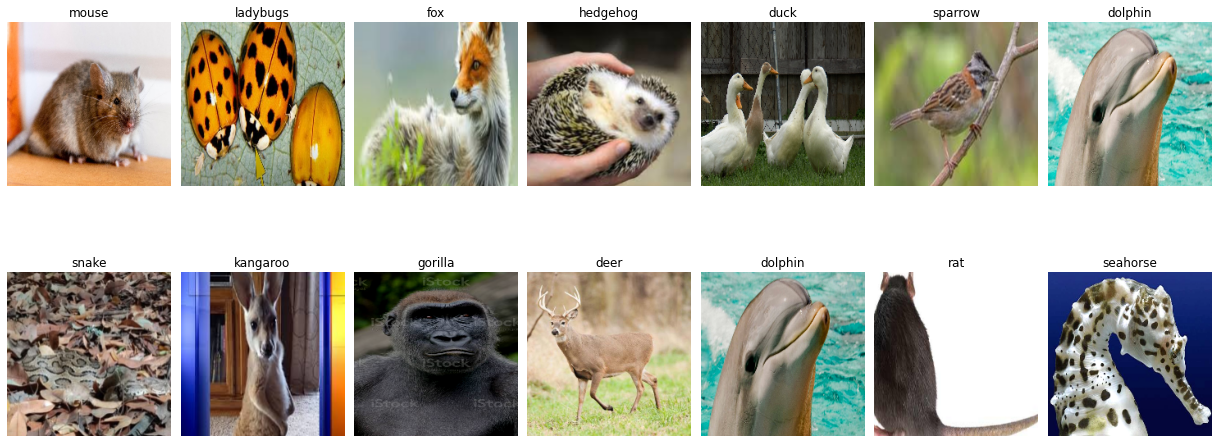

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline



def visualize_augmentations(dataset, idx=0, samples=14, cols=7, random_img = False):
    
    dataset = copy.deepcopy(dataset)

    # it is asking, if there is transform in that dataset, then take it as "t"
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))]) 
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(17, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(dataset))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_cls[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset, random_img = True)


# **TRANSFER LEARNING**

In [23]:
from torchvision.models import VGG16_Weights
model = models.vgg16(weights=VGG16_Weights.DEFAULT, progress=True)

### **FINE TUNNING**

In [24]:
# freezing training for all layers
for params in model.parameters():
    params.requires_grad = False

### **ADDING FINAL LAYERS**

In [25]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=90, bias=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# **MODEL BUILDING**

### **Hyper-parameters**

In [27]:
from torch.optim import lr_scheduler
import time
from torch.utils.tensorboard import SummaryWriter


### **Training Pase**

---

In [36]:
# from tabnanny import verbose
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping 
# callback = EarlyStopping(monitor='train_loss', patience=2,mode='min', verbose=True)

In [28]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device=device)
lambda2 = lambda epoch: 0.95**epoch
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda2)
writer = SummaryWriter()

In [29]:
def train_model(model, criterion, optimizer,scheduler, num_epochs=3, checkpoint=True):
    # Early stopping
    last_loss = 100
    patience = 2
    trigger_times = 0   
    Training_Loss = []
    Validation_Loss = []

    since = time.time() 

    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

            

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Loss 
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Optimization
                # with torch.no_grad if phase=='Train':
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                _, preds = torch.max(outputs, 1)  # 1 = Row wise max, preds = index of max predicted image, for comparing to label
                running_loss += loss.item() * inputs.size(0)  # for getting Cost 
                running_corrects += torch.sum(preds == labels.data)

            if phase=='train':
                epoch_loss = running_loss / len(train_dataset)
                Training_Loss.append(epoch_loss)
                epoch_acc = running_corrects.double() / len(train_dataset)
                print(f'{phase} loss is: {epoch_loss:.4f}, and accuracy is : {epoch_acc:.4f}')
                
            else:
                epoch_loss = running_loss / len(test_dataset) # lenght will be same for val, train
                epoch_acc = running_corrects.double() / len(test_dataset)
                Validation_Loss.append(epoch_loss)
                print(f'{phase} loss is: {epoch_loss:.4f}, and accuracy is: {epoch_acc:.4f}\n')
                
                # Custom Early Stopping
                if epoch_loss > last_loss:
                    trigger_times += 1
                    print('Trigger Times:', trigger_times)

                    if trigger_times >= patience:
                        print('Early stopping!\nStart to test process.')
                        return model

                else:
                    print('Trigger Times: 0')
                    trigger_times = 0

                last_loss = epoch_loss
    
    # Extra Stuff
    
    # 0) Saving CheckPoints
    if checkpoint:
        print("==> saving checkpoints")
        checkpoint = {'State_dic':model.state_dict(), 'Optimizer': optimizer.state_dict()}
        torch.save(checkpoint, 'checkpoint.tar')
    
    # 1) Time Calculation
    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m { time_elapsed % 60:.0f}s')
    
    # 2) Plotting Graphs
    print("\nGraphs of Losses")
    epochGraph = range(1, num_epochs+1)
    figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    figure.suptitle("Losses w.r.t Epochs", weight='bold', size=30)
    ax1.set_title('Training loss')
    ax1.plot(epochGraph,Training_Loss, 'tab:orange')
    ax2.set_title('Validation loss')
    ax2.plot( epochGraph,Validation_Loss, 'tab:green')

    # 3) Making TansorBoard
    # writer.add_scalar("Training Loss", Training_Loss, torch.tensor(epochGraph))
    # writer.add_scalar("Validation Loss", Validation_Loss, torch.tensor(epochGraph))

    
    return model

In [32]:
import os 
os.getcwd()

'c:\\Users\\Abu Ubaida\\Desktop\\Projects\\DL_Projects\\Deep_Learning_Projects'

In [66]:
# from cProfile import label


# num_epochs = 5
# Training_Loss = range(-5, 11,)
# Validation_Loss = range(-11, 16)
# print("\nGraphs of Losses")
# epochGraph = range(1, num_epochs+1)
# # figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
# # figure.suptitle("Losses w.r.t Epochs", weight='bold', size=30)
# # ax1.set_title('Training loss')
# # ax1.plot(Training_Loss, 'tab:orange', label='Training Loss')
# # ax2.set_title('Validation loss')
# # ax2.plot(Validation_Loss, 'tab:green', label='Validation Loss')
# plt.plot(Training_Loss, label = 'Training Loss')
# plt.plot(Validation_Loss, label = 'Validation Loss')
# plt.legend()

In [ ]:
train_model(model, criterion, optimizer, scheduler, num_epochs=5, checkpoint=True)

### **Loading CheckPoints**

In [33]:
checkpoint = torch.load('checkpoint.tar')
model.load_state_dict(checkpoint['State_dic'])
optimizer.load_state_dict(checkpoint['Optimizer'])


Epoch 1/4
----------
train loss is: 2.1062, and accuracy is : 0.4994
validation loss is: 0.8570, and accuracy is: 0.7667

Trigger Times: 0

Epoch 2/4
----------
train loss is: 1.9881, and accuracy is : 0.5494
validation loss is: 0.8409, and accuracy is: 0.7593

Trigger Times: 0

Epoch 3/4
----------
train loss is: 2.0387, and accuracy is : 0.5222
validation loss is: 0.8518, and accuracy is: 0.7648

Trigger Times: 1

Epoch 4/4
----------
train loss is: 2.0169, and accuracy is : 0.5435
validation loss is: 0.8435, and accuracy is: 0.7602

Trigger Times: 0
==> saving checkpoints

Training complete in 138m 18s

Graphs of Losses


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

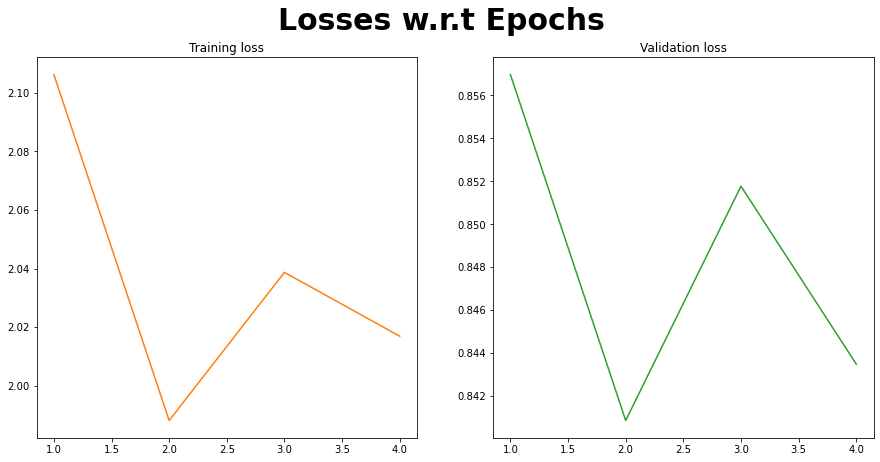

In [40]:
train_model(model, criterion, optimizer, scheduler, num_epochs=4, checkpoint=True)


In [34]:
checkpoint1 = torch.load('checkpoint.tar')
model.load_state_dict(checkpoint['State_dic'])
optimizer.load_state_dict(checkpoint['Optimizer'])

## **Checking Accuracy on Test Data**

In [35]:
def check_accuracy(loader, model, train=True):
    num_correct = num_samples = 0
    model.eval()
    
    with torch.no_grad():
      for input, labels in loader:
        input = input.to(device=device)
        labels = labels.to(device=device)
        batch_size = input.shape[0]
    
        outputs = model(input)
        _, preds = outputs.max(1)
        num_correct += (preds == labels).sum()
        num_samples += preds.size(0)
    
    accuracy = (num_correct.item()/num_samples)*100
    
    print(f"Model Predicted {num_correct.item()} correctly out of {num_samples} from Testing dataset, Accuracy : {accuracy:.2f}")

    model.train()

# check_accuracy(dataloaders['train'], model)
check_accuracy (dataloaders['test'], model, train=False)
# 'Model Predicted 746 correctly out of 1080 from Testing dataset, Accuracy : 69.07'

Model Predicted 747 correctly out of 1080 from Testing dataset, Accuracy : 69.17
